# Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [2]:
# TODO could try different thresholds for played
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [3]:
train['played'] = 1

In [4]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 15)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 15)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,833,118
1,743,617
2,486,571
3,314,349
4,1050,910
...,...,...
546700,441,1018
546701,891,252
546702,946,384
546703,147,549


In [5]:
train = train.append(neg_train).drop_duplicates(subset=['game_id', 'user_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
477559,15,282,0
18605,380,379,1
22331,658,1025,0
397220,645,1098,0
76755,715,788,0
...,...,...,...
76082,665,237,0
272,21,2,1
146520,197,207,0
330151,65,177,0


In [6]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.9213455018656354
0.07865449813436459


In [7]:
# check to make sure didn't introduce conflicting neg training instances
train.groupby(by=['user_id']).agg({'game_id':lambda x: x.unique().size == x.size})['game_id'].all()

True

## Neural Network Construction

In [31]:
n_latent_factors = 20
n_epochs = 10 

### Multi-Layer Perceptron part of model

In [32]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='MLP-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='MLP-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='MLP-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='MLP-Flatten-Users')(user_embedding)

mlp_layer = keras.layers.concatenate([game_vec, user_vec], name="MLP-User-Games")

for i in [4, 2, 1, 0.5, 0.25, 0]:
  mlp_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  mlp_layer = Dense(math.floor(n_latent_factors * i), activation='relu', 
              kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  if i == 4:
    mlp_layer = BatchNormalization()(mlp_layer)
    mlp_layer = Dropout(0.2)(mlp_layer)

mlp = Model(inputs=[user_input, game_input], outputs=mlp_output)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [34]:
# train mlp weights
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
mlp_history = mlp.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 463381 samples
Epoch 1/10
463381/463381 [==============================] - 9s 19us/sample - loss: 0.2092 - binary_accuracy: 0.9265
Epoch 2/10
463381/463381 [==============================] - 8s 18us/sample - loss: 0.2086 - binary_accuracy: 0.9265
Epoch 3/10
463381/463381 [==============================] - 8s 18us/sample - loss: 0.2070 - binary_accuracy: 0.9269
Epoch 4/10
463381/463381 [==============================] - 8s 18us/sample - loss: 0.2062 - binary_accuracy: 0.9270
Epoch 5/10
463381/463381 [==============================] - 9s 18us/sample - loss: 0.2051 - binary_accuracy: 0.9271
Epoch 6/10
463381/463381 [==============================] - 8s 18us/sample - loss: 0.2041 - binary_accuracy: 0.9275
Epoch 7/10
463381/463381 [==============================] - 9s 18us/sample - loss: 0.2032 - binary_accuracy: 0.9277
Epoch 8/10
463381/463381 [==============================] - 8s 18us/sample - loss: 0.2023 - binary_accuracy: 0.9276
Epoch 9/10
463381/463381 [======================

Text(0, 0.5, 'Training Error')

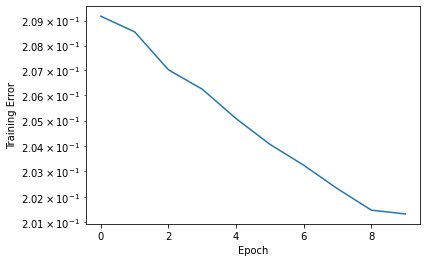

In [35]:
pd.Series(mlp_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [36]:
# lock mlp weights
mlp.trainable = False
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

### Generalized Matrix Factorization part of model

In [37]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='GMF-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='GMF-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='GMF-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='GMF-Flatten-Users')(user_embedding)

prod = keras.layers.dot([user_vec, game_vec], axes=1, name='Dot-Product')

gmf = Model(inputs=[user_input, game_input], outputs=prod)
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [38]:
# train gmf weights
gmf_history = gmf.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs)

Train on 463381 samples
Epoch 1/10
463381/463381 [==============================] - 5s 12us/sample - loss: 0.0657 - mae: 0.1110 - mse: 0.0655
Epoch 2/10
463381/463381 [==============================] - 5s 10us/sample - loss: 0.0619 - mae: 0.1217 - mse: 0.0616
Epoch 3/10
463381/463381 [==============================] - 5s 10us/sample - loss: 0.0612 - mae: 0.1220 - mse: 0.0609
Epoch 4/10
463381/463381 [==============================] - 5s 10us/sample - loss: 0.0593 - mae: 0.1218 - mse: 0.0590
Epoch 5/10
463381/463381 [==============================] - 5s 12us/sample - loss: 0.0575 - mae: 0.1213 - mse: 0.0571
Epoch 6/10
463381/463381 [==============================] - 5s 11us/sample - loss: 0.0559 - mae: 0.1206 - mse: 0.0554
Epoch 7/10
463381/463381 [==============================] - 5s 10us/sample - loss: 0.0546 - mae: 0.1197 - mse: 0.0540
Epoch 8/10
463381/463381 [==============================] - 6s 13us/sample - loss: 0.0535 - mae: 0.1188 - mse: 0.0528
Epoch 9/10
104960/463381 [=====>

KeyboardInterrupt: 

Text(0, 0.5, 'Training Error')

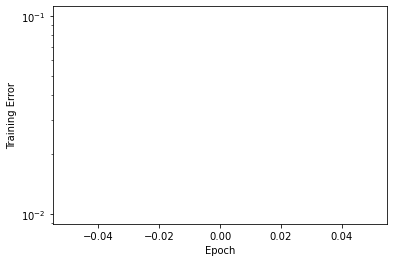

In [15]:
pd.Series(gmf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [16]:
# lock gmf weights
gmf.trainable = False
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [17]:
# Combining MLP and GMF parts of the model
mlp_gmf = Concatenate()([mlp.output, gmf.output])
ncf_output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='NCF-Output')(mlp_gmf)
ncf = Model([mlp.input, gmf.input], ncf_output)
ncf.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [18]:
ncf.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MLP-Game (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-User (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-Game-Embedding (Embedding)  (None, 1, 32)        33376       MLP-Game[0][0]                   
__________________________________________________________________________________________________
MLP-User-Embedding (Embedding)  (None, 1, 32)        37120       MLP-User[0][0]                   
____________________________________________________________________________________________

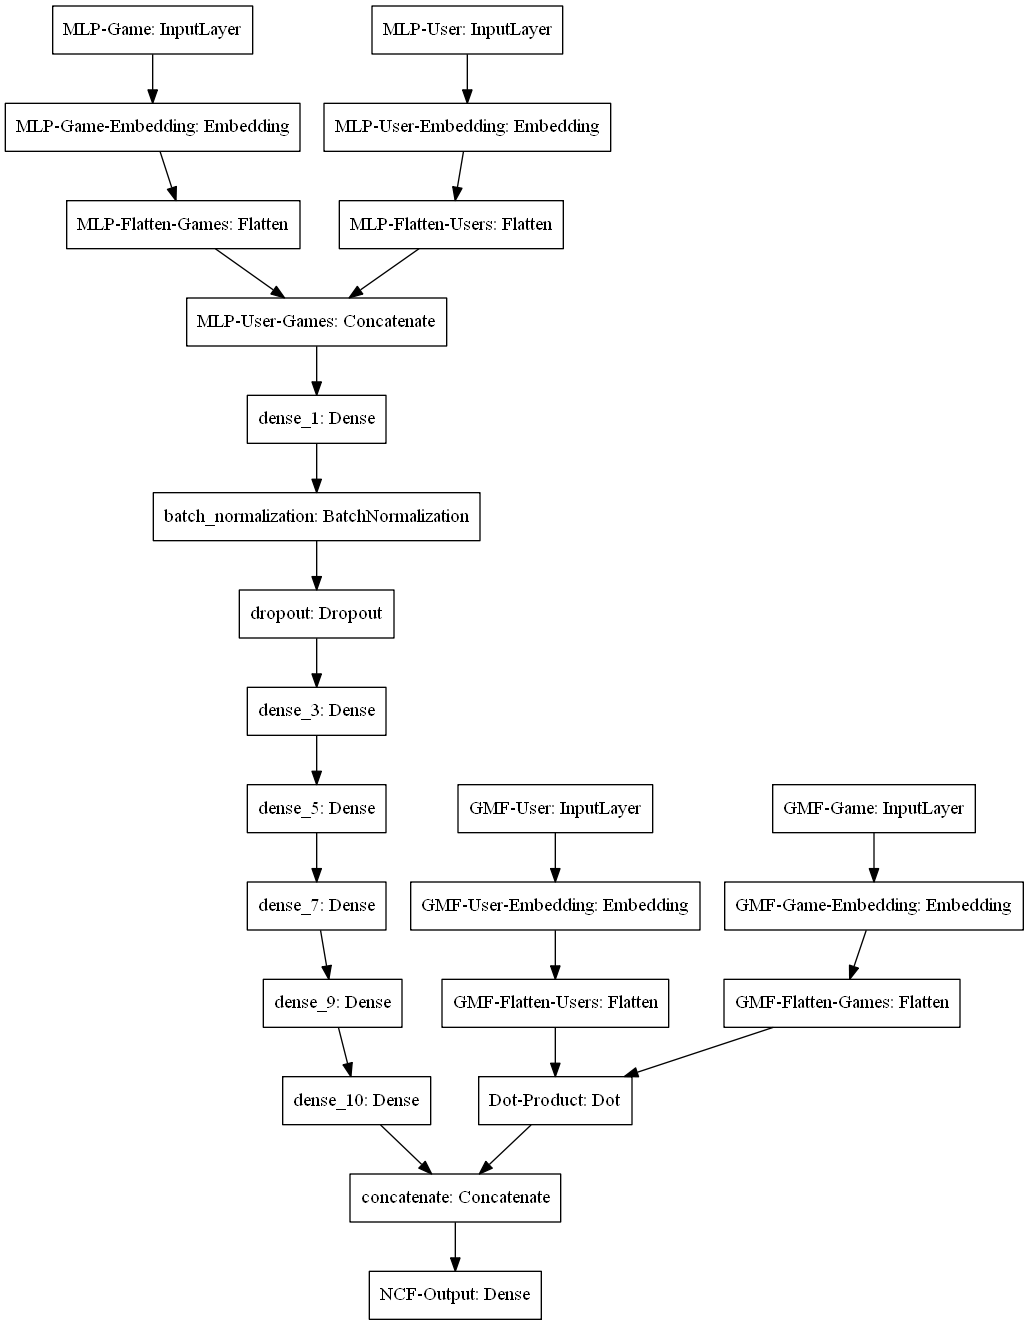

In [19]:
plot_model(ncf)

## Model Training

In [20]:
# train ncf
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
ncf_history = ncf.fit([train.user_id, train.game_id, train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 463381 samples
463381/463381 [==============================] - 8s 17us/sample - loss: 0.3659 - binary_accuracy: 0.9213


Text(0, 0.5, 'Training Error')

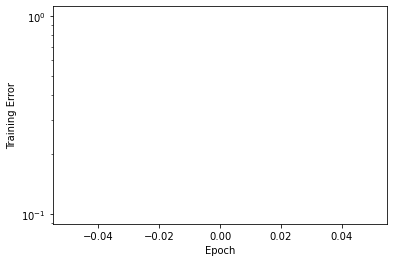

In [21]:
pd.Series(ncf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis

In [24]:
def recommend_game(uid, model, n=10):
    uid_array = np.repeat(uid, game_coding.game_id.size)
    recs = np.ndarray.flatten(model.predict([uid_array, game_coding.game_id, uid_array, game_coding.game_id]))
    recs_df =  pd.DataFrame({'game_id':game_coding.game_id, 'rec_confidence':recs})
    return set(recs_df.sort_values(by='rec_confidence', ascending=False).head(10).game_id)

In [25]:
test['recommended'] = np.vectorize(recommend_game)(test.user_id.unique(), ncf)

KeyboardInterrupt: 

In [22]:
test

,game_id,user_id,recommended
0,16,0,"{1, 6, 7, 296, 9, 271, 20, 23, 315, 637}"
1,35,1,"{1, 39, 74, 109, 141, 20, 23, 27, 156, 95}"
2,203,2,"{1, 39, 74, 141, 20, 244, 23, 89, 27, 156}"
3,265,3,"{1, 6, 7, 265, 74, 141, 48, 20, 21, 23}"
4,286,4,"{0, 1, 39, 296, 168, 141, 20, 23, 89, 27}"
...,...,...,...
1155,584,1155,"{353, 929, 399, 785, 786, 278, 344, 346, 381, ..."
1156,656,1156,"{353, 929, 399, 785, 786, 278, 344, 346, 381, ..."
1157,973,1157,"{353, 929, 399, 785, 786, 278, 344, 346, 381, ..."
1158,901,1158,"{353, 929, 399, 656, 785, 278, 344, 346, 381, ..."


In [26]:
test['in_recommendations'] = np.vectorize(lambda gid, recs: 1 if gid in recs else 0)(test.game_id, test.recommended)
test.in_recommendations.sum() / test.in_recommendations.size

0.11810344827586207

In [ ]:
games_recommended = set()
np.vectorize(lambda curr_games, total: total.update(curr_games))(test.recommended, games_recommended)